Important packeges to install
--

In [ ]:
pip install -U pandas numpy torch transformers datasets scikit-learn matplotlib seaborn tqdm huggingface_hub

# Transformer-Based Models: Fine-tune XLM-R for contextual understanding.

All necessarry packages
--

In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import json
import logging
from huggingface_hub import notebook_login
from datetime import datetime

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility

In [15]:
def load_data():
    """Load and prepare all data."""
    logger.info("Loading preprocessed data...")
    processed_train = pd.read_csv('/kaggle/input/sm-tec-generated-dataset/multilingual_processed_train_text.csv')
    processed_val = pd.read_csv('/kaggle/input/sm-tec-generated-dataset/multilingual_processed_val_text.csv')

    logger.info("Loading TF-IDF features...")
    train_tfidf = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_tfidf_features.npy')
    val_tfidf = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_tfidf_features.npy')

    logger.info("Loading Word2Vec features...")
    train_premise_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_premise_w2v.npy')
    train_hypothesis_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_hypothesis_w2v.npy')
    val_premise_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_premise_w2v.npy')
    val_hypothesis_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_hypothesis_w2v.npy')

    # Combine Word2Vec features
    train_w2v_combined = np.concatenate([train_premise_w2v, train_hypothesis_w2v, 
                                       train_premise_w2v - train_hypothesis_w2v,
                                       np.multiply(train_premise_w2v, train_hypothesis_w2v)], axis=1)
    val_w2v_combined = np.concatenate([val_premise_w2v, val_hypothesis_w2v, 
                                     val_premise_w2v - val_hypothesis_w2v,
                                     np.multiply(val_premise_w2v, val_hypothesis_w2v)], axis=1)

    # Print shapes to debug
    print(f"Original data shapes:")
    print(f"processed_train: {processed_train.shape}")
    print(f"processed_val: {processed_val.shape}")
    print(f"train_tfidf: {train_tfidf.shape}")
    print(f"val_tfidf: {val_tfidf.shape}")
    print(f"train_w2v_combined: {train_w2v_combined.shape}")
    print(f"val_w2v_combined: {val_w2v_combined.shape}")

    # Check label distribution
    print("\nLabel distribution in training data:")
    print(processed_train['label'].value_counts(dropna=False))
    print("\nLabel distribution in validation data:")
    print(processed_val['label'].value_counts(dropna=False))

    # Prepare labels (using integers directly)
    y_train = processed_train['label'].values
    y_val = processed_val['label'].values

    # Check for NaN values
    if np.isnan(y_train).any():
        print(f"Found {np.isnan(y_train).sum()} NaN values in y_train. Filling with 1...")
        y_train = np.nan_to_num(y_train, nan=1)
    if np.isnan(y_val).any():
        print(f"Found {np.isnan(y_val).sum()} NaN values in y_val. Filling with 1...")
        y_val = np.nan_to_num(y_val, nan=1)

    # Create texts for transformer models
    train_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                   for _, row in processed_train.iterrows()]
    val_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                 for _, row in processed_val.iterrows()]

    # Define label map for interpretation
    label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
    
    return {
        'processed_train': processed_train,
        'processed_val': processed_val,
        'train_tfidf': train_tfidf,
        'val_tfidf': val_tfidf, 
        'train_w2v_combined': train_w2v_combined,
        'val_w2v_combined': val_w2v_combined,
        'y_train': y_train,
        'y_val': y_val,
        'train_texts': train_texts,
        'val_texts': val_texts,
        'label_map': label_map
    }

# Execute the function
data = load_data()

Original data shapes:
processed_train: (9696, 19)
processed_val: (2424, 19)
train_tfidf: (9696, 10000)
val_tfidf: (2424, 10000)
train_w2v_combined: (9696, 1200)
val_w2v_combined: (2424, 1200)

Label distribution in training data:
label
0    3341
2    3251
1    3104
Name: count, dtype: int64

Label distribution in validation data:
label
0    835
2    813
1    776
Name: count, dtype: int64


In [16]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    print(f"Using device: cuda")
else:
    print(f"Using device: cpu")

Using device: cuda


# Cell 3: Helper functions for NLI dataset preparation


In [17]:
def preprocess_nli_dataset(texts, labels):
    """Convert to HuggingFace Dataset format"""
    dataset_dict = {
        'premise': [text['premise'] for text in texts],
        'hypothesis': [text['hypothesis'] for text in texts],
        'label': labels
    }
    return HFDataset.from_dict(dataset_dict)

In [18]:
def tokenize_function(examples, tokenizer, max_length=128):
    """Tokenize premise and hypothesis pairs"""
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

Compute Metrix funtion
--

In [19]:
def compute_metrics(pred):
    """
    Computes accuracy and other metrics for evaluation
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    
    # Generate full classification report
    report = classification_report(labels, preds, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1': report['macro avg']['f1-score'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall']
    }

xlm-roberta-traininng initialization
--

In [20]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Prepare data for transformers

In [21]:
train_texts = data['train_texts']
val_texts = data['val_texts']
y_train = data['y_train']
y_val = data['y_val']

print(f"Training examples: {len(train_texts)}")
print(f"Validation examples: {len(val_texts)}")

Training examples: 9696
Validation examples: 2424



# Initialize model and tokenizer

In [22]:
model_name = 'xlm-roberta-base'  # You can use 'xlm-roberta-large' if you have enough compute
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)


# Convert to HuggingFace datasets

In [23]:
print("Converting datasets to HuggingFace format...")
train_dataset = preprocess_nli_dataset(train_texts, y_train)
val_dataset = preprocess_nli_dataset(val_texts, y_val)

Converting datasets to HuggingFace format...


# Tokenize datasets

In [24]:
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(
    lambda examples: tokenize_function(examples, tokenizer, max_length=128),
    batched=True
)
tokenized_val = val_dataset.map(
    lambda examples: tokenize_function(examples, tokenizer, max_length=128),
    batched=True
)

Tokenizing datasets...


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

# Set format for PyTorch


In [25]:
tokenized_train.set_format(
    type='torch', 
    columns=['input_ids', 'attention_mask', 'label']
)
tokenized_val.set_format(
    type='torch', 
    columns=['input_ids', 'attention_mask', 'label']
)

# Cell 6: Initialize model

In [26]:
# Define device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=3  # entailment, neutral, contradiction
)
model.to(device)

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

 # Set up training arguments

In [27]:
model_id = f"xlm-roberta-nli-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
output_dir = f"./models/{model_id}"

# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=6, 
    per_device_train_batch_size=16,  # Adjust based on your GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,  # We'll push manually after training
    hub_strategy="end",
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU is available
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Cell 8: Create Trainer

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

# Cell 9: Train model
# This cell will take some time to execute depending on your dataset size and hardware
print("Starting training...")
trainer.train()

Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.051500,0.913688,0.589934,0.585092,0.594004,0.587022
2,0.869100,0.864519,0.642327,0.643318,0.666644,0.644758
3,0.727600,0.717006,0.708333,0.707913,0.708375,0.707875
4,0.508300,0.804248,0.701733,0.701352,0.706179,0.701360
5,0.300600,0.950273,0.706271,0.705744,0.710714,0.706657
6,0.180700,1.093437,0.718647,0.718033,0.718044,0.718055


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1818, training_loss=0.6189202984305235, metrics={'train_runtime': 1268.1664, 'train_samples_per_second': 45.874, 'train_steps_per_second': 1.434, 'total_flos': 3826721547436032.0, 'train_loss': 0.6189202984305235, 'epoch': 6.0})

compute_metrics
--

In [50]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch

def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions
    
    # Convert logits to probabilities
    pred_probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(pred_probs, axis=-1)

    # Calculate basic metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", cm)

    # ROC-AUC (One-vs-Rest for multiclass)
    roc_auc = roc_auc_score(labels, pred_probs, multi_class='ovr')
    print("ROC-AUC Score:", roc_auc)

    # Plot ROC Curve and Confusion Matrix
    plot_metrics(labels, pred_probs, cm)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

def plot_metrics(labels, pred_probs, cm):
    plt.figure(figsize=(14, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(labels, pred_probs[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()


In [46]:
print("Evaluating model...")
eval_result = trainer.evaluate()
print(eval_result)


Evaluating model...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 1.093436598777771, 'eval_accuracy': 0.7186468646864687, 'eval_f1': 0.7180332811108306, 'eval_precision': 0.7180440616024869, 'eval_recall': 0.7180552641689143, 'eval_runtime': 10.9886, 'eval_samples_per_second': 220.592, 'eval_steps_per_second': 3.458, 'epoch': 6.0}


# Evaluate on the validation dataset and visualize additional metrics

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Confusion Matrix:
 [[612 117 106]
 [121 534 121]
 [ 93 124 596]]
ROC-AUC Score: 0.8688464643085227


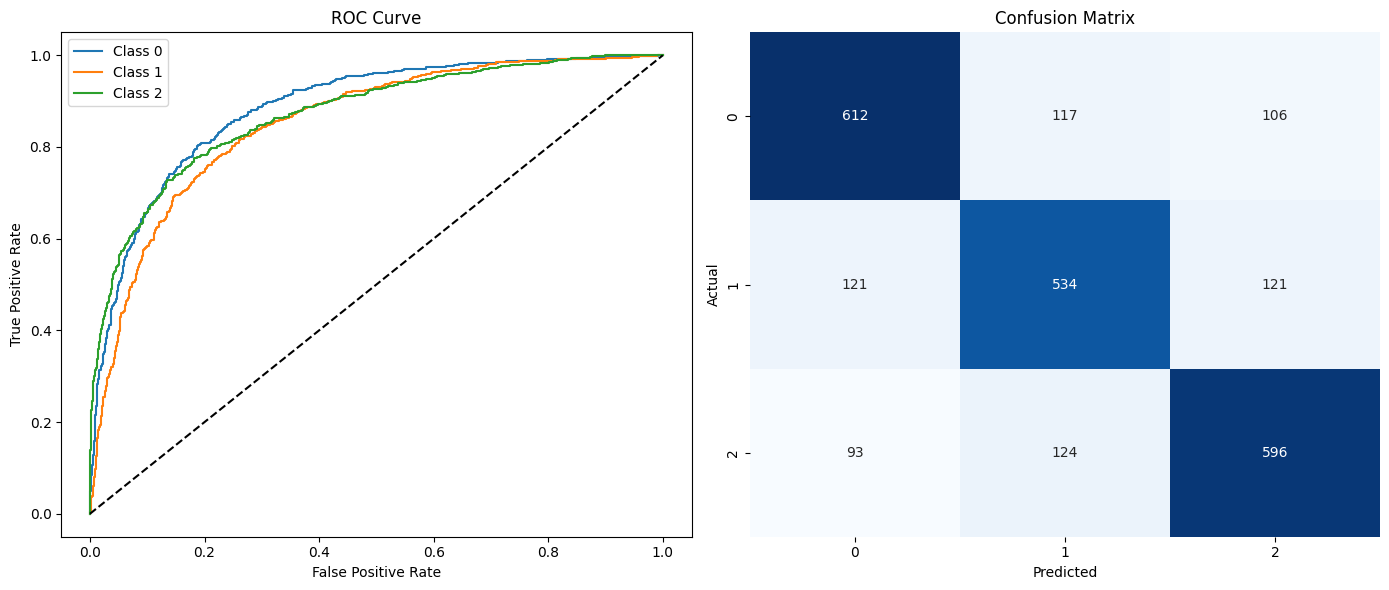

{'accuracy': 0.7186468646864687,
 'precision': 0.7180440616024869,
 'recall': 0.7180552641689143,
 'f1': 0.7180332811108306,
 'roc_auc': 0.8688464643085227}

In [51]:
predictions = trainer.predict(tokenized_val)
compute_metrics(predictions)


Deploy in hugging face
--

In [35]:
notebook_login()

# Upload model to Hugging Face Hub

In [40]:
# Define repository name for the model
repo_name = "multilingual-nli-xlm-roberta"  # Choose your repository name
model_repo_id = f"Fahim18/{repo_name}"  # Replace YOUR_HF_USERNAME with your Hugging Face username

# Create model card with information about your model
model_card = f"""
# XLM-RoBERTa for Multilingual NLI

This model is fine-tuned for multilingual Natural Language Inference (NLI) tasks.

## Model description

- **Model type:** XLM-RoBERTa
- **Task:** Natural Language Inference (Entailment Classification)
- **Training data:** Multilingual NLI dataset
- **Evaluation results:** 
  - Accuracy: {eval_result['eval_accuracy']:.4f}
  - F1 Score: {eval_result['eval_f1']:.4f}
  - Precision: {eval_result['eval_precision']:.4f}
  - Recall: {eval_result['eval_recall']:.4f}
  
## Usage

```python
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# Load model and tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("{model_repo_id}")
model = XLMRobertaForSequenceClassification.from_pretrained("{model_repo_id}")

# Prepare input
premise = "The dog is running in the park."
hypothesis = "There is an animal outdoors."

# Tokenize input
inputs = tokenizer(premise, hypothesis, return_tensors="pt", padding=True, truncation=True)

# Make prediction
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=1)

# Map predictions to labels
label_map = {{0: "entailment", 1: "neutral", 2: "contradiction"}}
result = label_map[predictions.item()]
print(f"Prediction: {{result}}")
```

## Limitations and bias

This model was trained on specific NLI data and may not generalize well to all domains or languages.
"""


# Upload to Hub
# This will push the model, tokenizer, and configuration to Hugging Face Hub
print(f"Pushing model to Hugging Face Hub: {model_repo_id}")
model.push_to_hub(model_repo_id)
tokenizer.push_to_hub(model_repo_id)



print(f"Model successfully uploaded to https://huggingface.co/{model_repo_id}")


Pushing model to Hugging Face Hub: Fahim18/multilingual-nli-xlm-roberta


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Model successfully uploaded to https://huggingface.co/Fahim18/multilingual-nli-xlm-roberta


# Test the uploaded model

In [39]:

from transformers import pipeline

# Load the model directly from the Hub
nli_pipeline = pipeline("text-classification", model=model_repo_id)

# Test with sample inputs
test_examples = [
    {"premise": "The cat is on the mat.", "hypothesis": "There is a cat."},
    {"premise": "The car is red.", "hypothesis": "The vehicle has a color."},
    {"premise": "The water is boiling.", "hypothesis": "The water is cold."}
]

for example in test_examples:
    # Format the input as expected by the model
    text = f"{example['premise']} </s> {example['hypothesis']}"
    result = nli_pipeline(text)[0]
    print(f"Premise: {example['premise']}")
    print(f"Hypothesis: {example['hypothesis']}")
    print(f"Prediction: {result['label']}, Score: {result['score']:.4f}")
    print("-" * 50)

Device set to use cuda:0


Premise: The cat is on the mat.
Hypothesis: There is a cat.
Prediction: LABEL_0, Score: 0.9921
--------------------------------------------------
Premise: The car is red.
Hypothesis: The vehicle has a color.
Prediction: LABEL_0, Score: 0.9890
--------------------------------------------------
Premise: The water is boiling.
Hypothesis: The water is cold.
Prediction: LABEL_2, Score: 0.9939
--------------------------------------------------
